# Self Curation

# Install All the Required Packages

In [1]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 datasets

In [14]:
# pip install tensorboardX

In [91]:
dataset.push_to_hub("Arnab13/LIMA-Generated-Instruct")

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Arnab13/LIMA-Generated-Instruct/commit/7af0d1c3369da114f8a8b70798730a33fc5b3de2', commit_message='Upload dataset', commit_description='', oid='7af0d1c3369da114f8a8b70798730a33fc5b3de2', pr_url=None, pr_revision=None, pr_num=None)

In [163]:
# Load the base model and tokenizer
model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


In [112]:
# Create a pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1500)

In [1]:
# Evaluation prompt
eval_prompt = """
Below is an instruction from an user and a candidate answer. 
Evaluate whether or not the answer is a good example of how AI Assistant should respond to the user’s instruction. 
Please assign a score using the following 5-point scale:

1: It means the answer is incomplete, vague, off-topic, controversial, or not exactly what the user asked for. 
For example, some content seems missing, numbered list does not start from the beginning, the opening sentence repeats user’s question. 
Or the response is from another person’s perspective with their personal experience (e.g. taken from blog posts), or looks like an answer from a forum. 
Or it contains promotional text, navigation text, or other irrelevant information.

2: It means the answer addresses most of the asks from the user. It does not directly address the user’s question. 
For example, it only provides a high-level methodology instead of the exact solution to user’s question.

3: It means the answer is helpful but not written by an AI Assistant. 
It addresses all the basic asks from the user. 
It is complete and self contained with the drawback that the response is not written from an AI assistant’s perspective, but from other people’s perspective. 
The content looks like an excerpt from a blog post, web page, or web search results. 
For example, it contains personal experience or opinion, mentions comments section, or share on social media, etc.

4: It means the answer is written from an AI assistant’s perspective with a clear focus of addressing the instruction. 
It provide a complete, clear, and comprehensive response to user’s question or instruction without missing or irrelevant information.
It is well organized, self-contained, and written in a helpful tone. 
It has minor room for improvement, e.g. more concise and focused.

5: It means it is a perfect answer from an AI Assistant. 
It has a clear focus on being a helpful AI Assistant, where the response looks like intentionally written to address the user’s question or instruction without any irrelevant sentences. 
The answer provides high quality content, demonstrating expert knowledge in the area, is very well written, logical, easy-to-follow, engaging and insightful.

Please first provide a brief reasoning you used to derive the rating score, and then write "Score: <rating>" in the last line.
"""

In [123]:
# Create lists to store results  
scores = []  
generated_responses = [] 

In [124]:
# Iterate through the dataset  
for i in tqdm(range(len(dataset))):  
    generated_instruction = dataset[i]['generated_instruction']  
    response = dataset[i]['response']  
  
    # Generate text using the pipeline  
    result = pipe(f"<s>[INST] {eval_prompt} Instruction: {generated_instruction} \n Response: {response} [/INST]")  
    gen_text = result[0]['generated_text'].split('[/INST]')[-1].strip()  
    generated_responses.append(gen_text)  
  
    # Extract score if it exists in the response  
    if 'Score: ' in gen_text:  
        scores.append(gen_text.split('Score: ')[-1][0])  
    else:  
        scores.append(None)  # or some default value  

  7%|▋         | 10/150 [01:08<15:53,  6.81s/it]/home/jovyan/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 150/150 [14:50<00:00,  5.94s/it]


In [127]:
# Add the new columns to the dataset  
dataset = dataset.add_column("Score", scores)  
dataset = dataset.add_column("generated_response", generated_responses)  

In [128]:
# Filter out rows with missing scores  
filtered_dataset = dataset.filter(lambda example: example['Score'] is not None)   

Filter: 100%|██████████| 150/150 [00:00<00:00, 44900.49 examples/s]


In [130]:
# Push to Hugging Face Hub  
filtered_dataset.push_to_hub("Arnab13/LIMA-Generated-Instruct-self-curated") 

Uploading the dataset shards: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/Arnab13/LIMA-Generated-Instruct-self-curated/commit/0f8b0ed7fab528a101372553c7851bcbe2c83f17', commit_message='Upload dataset', commit_description='', oid='0f8b0ed7fab528a101372553c7851bcbe2c83f17', pr_url=None, pr_revision=None, pr_num=None)

### Printing out High Quality Examples

In [135]:
sorted_dataset = filtered_dataset.sort("Score", reverse=True)
for i in range(5):  
    print(f"Instruction: \n{sorted_dataset[i]['generated_instruction']}")  
    print(f"Response: \n{sorted_dataset[i]['response']}")  
    print(f"Score: {sorted_dataset[i]['Score']}")  
    print("-" * 80)  

Instruction: 
What is the plan that the writer has in mind?  Please give the details of the plan.  What are the steps that the writer will take?  What will be the outcome of the plan?  What are the risks involved in the plan?  What are the consequences of the plan?  Please provide a detailed answer to the above question.
Response: 
He titled his first two works “Rough Draft”.
This time he called it “Completed Draft”.

He let his friend in on the plan when they met up face-to-face.
Firstly, he sent her fake text messages outlining how this time he was "very confident" he knew how to keep his works safe on his PC from ‘hackers’.
He sent a text stating that he would create a handwritten draft that would be fully edited, which he would then type up on his  computer in a few hours on the 25th of May and publish quickly within 24 hours.
It was a win-win situation.
He knew that if the hacker wasn't watching his texts, he would be able to publish his novel.
But if they were, they'd be caught o

### Printing out Low Quality Examples

In [136]:
sorted_dataset = filtered_dataset.sort("Score")
for i in range(5):  
    print(f"Instruction: \n{sorted_dataset[i]['generated_instruction']}")  
    print(f"Response: \n{sorted_dataset[i]['response']}")  
    print(f"Score: {sorted_dataset[i]['Score']}")  
    print("-" * 80) 

Instruction: 
What is the bus doing?
Response: 
I saw the bus screech out of the parking lot, and I knew that my target hoped to evade me by going on a field trip. My arms and legs moved like pistons to propel myself at a speed no human could ever hope to match. As soon as I latched onto it, the bus configured itself into the shape of a spaceship. Before it had so much as risen into the upper atmosphere, I had melted myself into liquid metal and seeped through a window. "Seatbelts, everyone!" a cheery voice at the front of the bus called.
I reformed into my usual police officer shape and pulled out my pistol. "I knew I should have stayed home today!" a nerdy red-haired kid said. After snapping his neck, the other kids cleared out of the aisle so I could get to my target. The woman in question danced her fingers over the controls. "Come on bus, do your stuff!" she said frantically as I approached. I grabbed her by her frizzy red hair as she she tried to shield herself with an overgrown 

In [148]:
df = pd.DataFrame(filtered_dataset)
df.Score.astype(int).value_counts()

Score
3    86
4    26
2    21
1     8
5     7
Name: count, dtype: int64

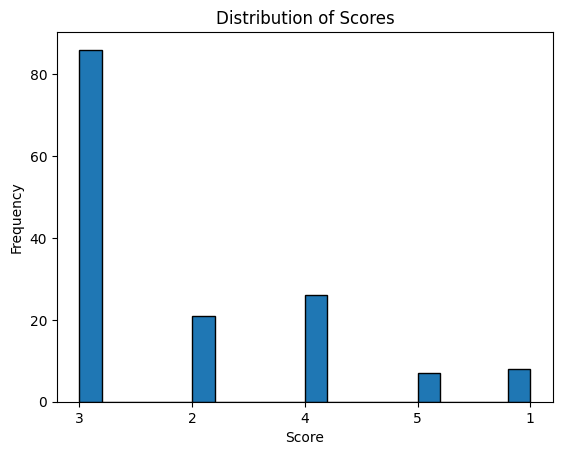

In [140]:
import matplotlib.pyplot as plt  
# Plot the distribution of scores  
filtered_scores = filtered_dataset['Score']  
plt.hist(filtered_scores, bins=20, edgecolor='black')  
plt.title('Distribution of Scores')  
plt.xlabel('Score')  
plt.ylabel('Frequency')  
plt.show() 